In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy

In [4]:
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# MNIST dataset loading
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=True, 
                                        transform=transforms.ToTensor(),  
                                        download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                       train=False, 
                                       transform=transforms.ToTensor())


# Data loader
def train_loader(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader


In [6]:
# Train function
def train(model, num_epochs, train_loader, optimizer, loss_func, status):
    model.train()
    train_losses = []
    train_acc = []
    
    for epoch in range(num_epochs):
        correct, total, epoch_loss = 0, 0, 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images), Variable(labels)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()

            if (i+1) % status == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}", end='\r')

        train_losses.append(epoch_loss / len(train_loader))
        train_acc.append(100 * correct / total)
    
    return train_losses, train_acc


In [7]:
# Test function
def test(model, test_loader, loss_func):
    model.eval()
    correct, total, test_loss = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = Variable(images), Variable(labels)
            outputs = model(images)
            
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return accuracy, test_loss

In [8]:
# Function to create models with different batch sizes
def create_and_train_model(batch_size, num_epochs=15, lr=0.0015, status=500):
    model = M1()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_func = nn.CrossEntropyLoss()
    
    print(f"Training model with batch size {batch_size}")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    train_losses, train_acc = train(model, num_epochs, train_loader, optimizer, loss_func, status)
    return model, train_losses, train_acc


In [9]:
# Training two models with different batch sizes
model_64, train_losses_64, train_acc_64 = create_and_train_model(batch_size=64, status=500)
model_1000, train_losses_1000, train_acc_1000 = create_and_train_model(batch_size=1000, status=5)


Training model with batch size 64
Training model with batch size 1000: 0.1014


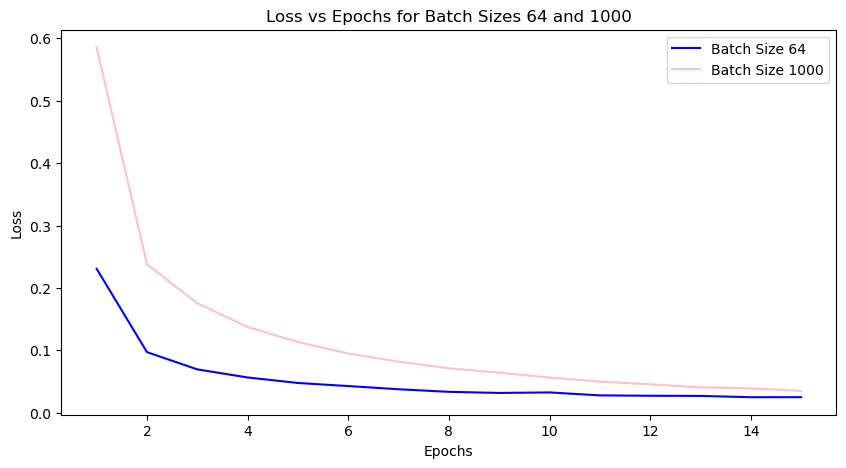

In [10]:
# Plot loss comparison
epochs = np.arange(1, 16)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_64, label='Batch Size 64', color='blue')
plt.plot(epochs, train_losses_1000, label='Batch Size 1000', color='pink')
plt.title('Loss vs Epochs for Batch Sizes 64 and 1000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Parameters interpolation
batch1_param = torch.nn.utils.parameters_to_vector(model_64.parameters())
batch2_param = torch.nn.utils.parameters_to_vector(model_1000.parameters())

alpha_values = np.linspace(-2.0, 2.0, num=31)
theta_params = [(1-alpha)*batch1_param + alpha*batch2_param for alpha in alpha_values]


In [12]:
train_loss_arr, test_loss_arr, train_acc_arr, test_acc_arr = [], [], [], []

for theta in theta_params:
    interpolated_model = M1()
    torch.nn.utils.vector_to_parameters(theta, interpolated_model.parameters())
    
    train_loader_interp = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True)
    test_loader_interp = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)
    
    train_loss, train_acc = train(interpolated_model, num_epochs=1, train_loader=train_loader_interp, optimizer=optim.Adam(interpolated_model.parameters()), loss_func=nn.CrossEntropyLoss(), status=100)
    train_loss_arr.append(np.mean(train_loss))
    train_acc_arr.append(np.mean(train_acc))
    
    test_acc, test_loss = test(interpolated_model, test_loader_interp, loss_func=nn.CrossEntropyLoss())
    test_acc_arr.append(test_acc)
    test_loss_arr.append(test_loss)


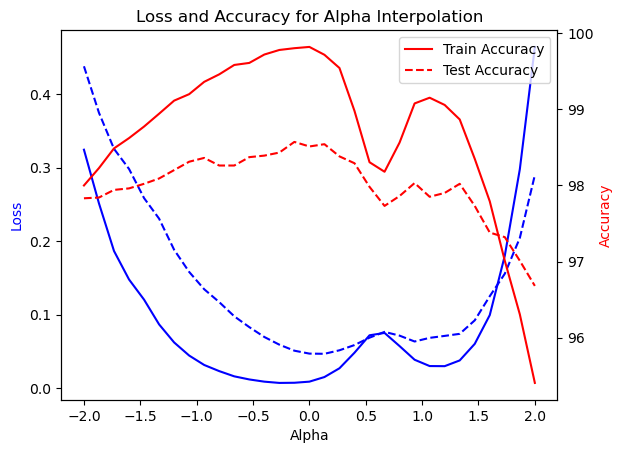

In [13]:
fig, ax1 = plt.subplots()

ax1.plot(alpha_values, train_loss_arr, 'b-', label='Train Loss')
ax1.plot(alpha_values, test_loss_arr, 'b--', label='Test Loss')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(alpha_values, train_acc_arr, 'r-', label='Train Accuracy')
ax2.plot(alpha_values, test_acc_arr, 'r--', label='Test Accuracy')
ax2.set_ylabel('Accuracy', color='r')

plt.title('Loss and Accuracy for Alpha Interpolation')
plt.legend()
plt.show()

In [14]:
# Function to calculate and print the total number of parameters in a model
def count_model_params(model):
    params_count = sum(torch.numel(p) for p in model.parameters())
    print(f'Total number of parameters in the model: {params_count}')
    return params_count



In [16]:
def trainFunc(model, max_epochs, batch_size, loss_func, optimizer, status_interval):
    # Load the MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True
    )
    
    model.train()
    avg_loss = []
    correct = 0
    total = 0

    for epoch in range(max_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss.append(total_loss / len(train_loader))
        accuracy = 100 * correct / total

        if (epoch + 1) % status_interval == 0:
            print(f'Epoch [{epoch + 1}/{max_epochs}], Loss: {avg_loss[-1]:.4f}, Accuracy: {accuracy:.2f}%')
    
    return max_epochs, total_loss, accuracy, avg_loss, accuracy  # Returning 5 values

# Training setup for learning rate 1e-3
learning_rate1 = 1e-3
model_lr1 = M1()
loss_fn = nn.CrossEntropyLoss()
optimizer_lr1 = torch.optim.Adam(model_lr1.parameters(), lr=learning_rate1)

count_model_params(model_lr1)

max_epochs = 5
batch_size_train = 64
status_interval = 10

# Train the model with learning rate 1e-3
lr1_train_epoch, lr1_train_loss, lr1_train_acc, lr1_avg_loss, lr1_avg_acc = trainFunc(
    model_lr1, max_epochs, batch_size_train, loss_fn, optimizer_lr1, status_interval
)


Total number of parameters in the model: 397510


In [17]:
# Save model parameters as a vector
lr1_params_vector = torch.nn.utils.parameters_to_vector(model_lr1.parameters())
print(f'Parameter vector for model with lr={learning_rate1}:\n{lr1_params_vector}\nLength: {len(lr1_params_vector)}')


Parameter vector for model with lr=0.001:
tensor([-0.0020,  0.0184, -0.0183,  ..., -0.0210,  0.0693, -0.0233],
       grad_fn=<CatBackward0>)
Length: 397510


In [18]:
# Training setup for learning rate 1e-2
learning_rate2 = 1e-2
model_lr2 = M1()
optimizer_lr2 = torch.optim.Adam(model_lr2.parameters(), lr=learning_rate2)

count_model_params(model_lr2)  # Print model parameters



Total number of parameters in the model: 397510


397510

In [19]:
# Train the model with learning rate 1e-2
lr2_train_epoch, lr2_train_loss, lr2_train_acc, lr2_avg_loss, lr2_avg_acc = trainFunc(
    model_lr2, max_epochs, batch_size_train, loss_fn, optimizer_lr2, status_interval
)


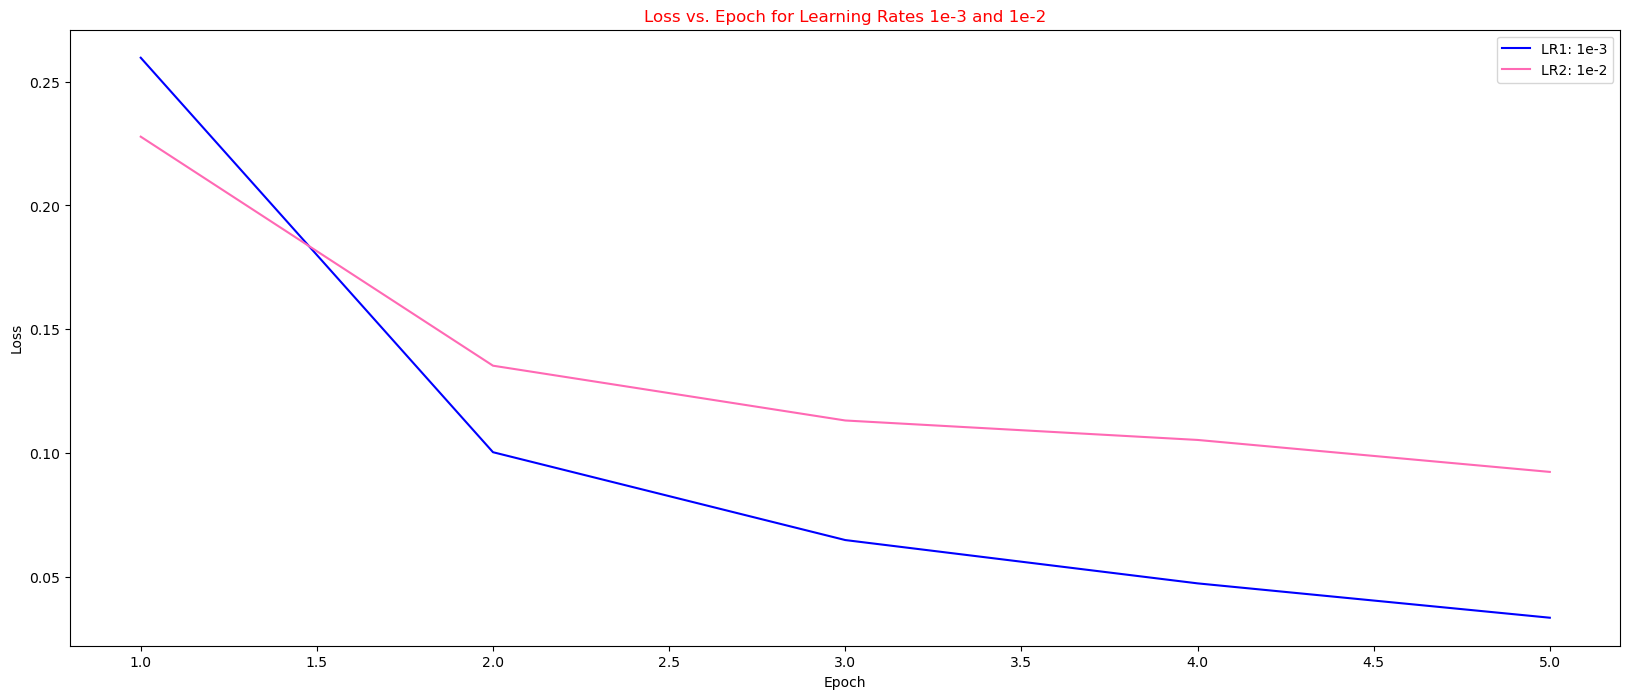

In [20]:
# Plotting loss curves for both learning rates
epochs_array = np.linspace(1, max_epochs, max_epochs)
plt.figure(figsize=(20, 8))
plt.plot(epochs_array, lr1_avg_loss, color="blue", label="LR1: 1e-3")
plt.plot(epochs_array, lr2_avg_loss, color="hotpink", label="LR2: 1e-2")
plt.title('Loss vs. Epoch for Learning Rates 1e-3 and 1e-2', color="red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./output/learning_rate_comparison_loss.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [21]:
# Save parameters for second model
lr2_params_vector = torch.nn.utils.parameters_to_vector(model_lr2.parameters())
print(f'Parameter vector for model with lr={learning_rate2}:\n{lr2_params_vector}\nLength: {len(lr2_params_vector)}')


Parameter vector for model with lr=0.01:
tensor([-1.9525e-03, -4.9539e-03,  1.0094e-02,  ..., -3.9941e-01,
         2.0333e+00,  3.8334e-01], grad_fn=<CatBackward0>)
Length: 397510


In [22]:
# Initialize lists to store results for the combined model
train_loss_combined = []
train_acc_combined = []
test_loss_combined = []
test_acc_combined = []

alpha = np.linspace(0, 1, num=10)


In [29]:
# Iterate through alpha values to combine models
for idx, alpha_value in enumerate(alpha):
    torch.manual_seed(1)
    
    interpolated_params = (1 - alpha_value) * lr1_params_vector + alpha_value * lr2_params_vector
    combined_model = M1()
    torch.nn.utils.vector_to_parameters(interpolated_params, combined_model.parameters())
    
    count_model_params(combined_model)
    optimizer_combined = torch.optim.Adam(combined_model.parameters(), lr=1e-3)

    max_epochs_combined = 1
    train_batch_size_combined = 1000
    status_combined = 60

    combined_train_epoch, combined_train_loss, combined_train_acc, combined_avg_loss, combined_avg_acc = trainFunc(
        combined_model, max_epochs_combined, train_batch_size_combined,loss_fn, optimizer_combined, status_combined
    )
    
    train_loss_combined.append(combined_avg_loss)
    train_acc_combined.append(combined_avg_acc)
    
    test_loader_combined = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)
    
    # Evaluating the combined model on the test set
    test_batch_size_combined = 1000
    test_acc, test_loss = test(combined_model, test_loader_combined, loss_fn)
    test_acc_combined.append(test_acc)
    test_loss_combined.append(test_loss)


Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510
Total number of parameters in the model: 397510


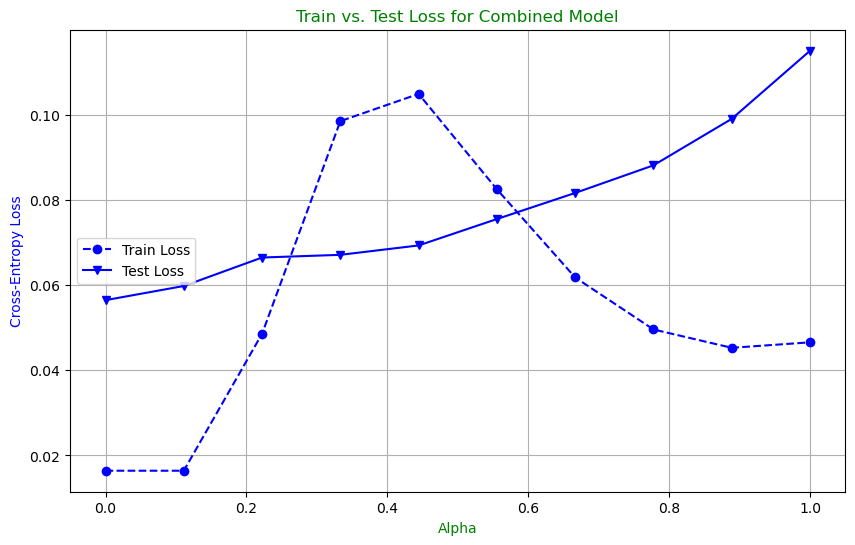

In [40]:
import numpy as np

alpha = np.array(alpha)

train_loss_combined = np.array(train_loss_combined).reshape(-1)
test_loss_combined = np.array(test_loss_combined).reshape(-1)

min_length = min(len(alpha), len(train_loss_combined), len(test_loss_combined))
alpha = alpha[:min_length]
train_loss_combined = train_loss_combined[:min_length]
test_loss_combined = test_loss_combined[:min_length]

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(alpha, train_loss_combined, color="blue", linestyle='dashed', marker="o", label="Train Loss")
ax.plot(alpha, test_loss_combined, color="blue", marker="v", label="Test Loss")

# Set labels, title, and legend
ax.set_xlabel("Alpha", color="green")
ax.set_ylabel("Cross-Entropy Loss", color="blue")
ax.set_title("Train vs. Test Loss for Combined Model", color="green")

# Adjust the legend position
ax.legend(loc="center left")

# Add grid for better visualization
ax.grid(True)

# Display the plot
plt.show()


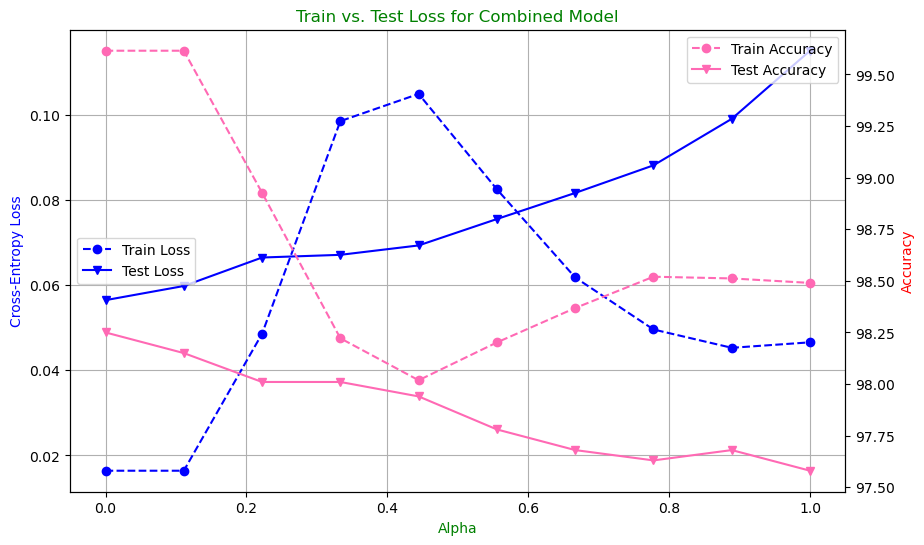

In [39]:
import numpy as np

# Convert lists to NumPy arrays if needed
alpha = np.array(alpha)

train_acc_combined = np.array(train_acc_combined).reshape(-1)
test_acc_combined = np.array(test_acc_combined).reshape(-1)

min_length_acc = min(len(alpha), len(train_acc_combined), len(test_acc_combined))
alpha = alpha[:min_length_acc]
train_acc_combined = train_acc_combined[:min_length_acc]
test_acc_combined = test_acc_combined[:min_length_acc]


fig, ax = plt.subplots(figsize=(10, 6))

# Plot loss
ax.plot(alpha, train_loss_combined, color="blue", linestyle='dashed', marker="o", label="Train Loss")
ax.plot(alpha, test_loss_combined, color="blue", marker="v", label="Test Loss")
ax.set_xlabel("Alpha", color="green")
ax.set_ylabel("Cross-Entropy Loss", color="blue")
ax.set_title("Train vs. Test Loss for Combined Model", color="green")
ax.legend(loc="center left")

# Plot accuracy on the second y-axis
ax2 = ax.twinx()  # Create a second y-axis
ax2.plot(alpha, train_acc_combined, color="hotpink", linestyle='dashed', marker="o", label="Train Accuracy")
ax2.plot(alpha, test_acc_combined, color="hotpink", marker="v", label="Test Accuracy")
ax2.set_ylabel("Accuracy", color="red")
ax2.legend(loc="best")

ax.grid(True)

plt.show()

